# Final Project
## Data Processing

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import pystan
import csv
from datetime import date
from datetime import timedelta
import pandas
import seaborn

In [2]:
# import data from the csv file
raw_data = []
with open('weekly_in_situ_co2_mlo.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        raw_data.append(row)
just_values =raw_data[44::]

In [3]:
# convert dates to time since 
raw_dates = [point[0] for point in just_values]
datetime_dates = [date.fromisoformat(x) for x in raw_dates]
time = [(date.fromisoformat(x)-date.fromisoformat(just_values[0][0]))/timedelta(days = 1) for x in raw_dates]
# extract the co2 data set
co2_data = [float(point[1]) for point in just_values]

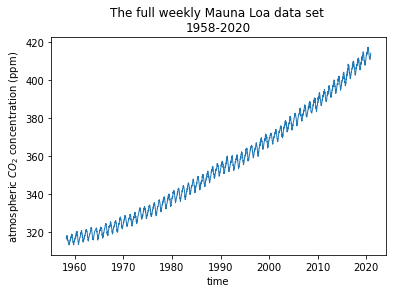

In [4]:
# plot full data
plt.plot_date(datetime_dates, co2_data,  linestyle = 'solid' , linewidth=1, markersize=0)
plt.title('The full weekly Mauna Loa data set \n1958-2020')
plt.ylabel('atmospheric $CO_2$ concentration (ppm)')
plt.xlabel('time')
plt.show()

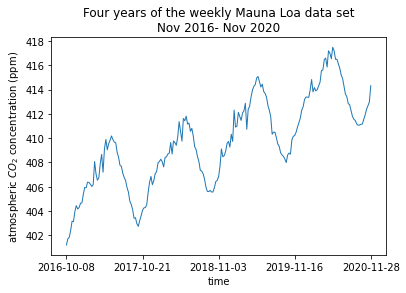

In [5]:
plt.plot_date(datetime_dates[-54*4::], co2_data[-54*4::], linestyle = 'solid' , linewidth=1, markersize=0)
plt.xticks(np.arange(min(datetime_dates[-54*4::]), max(datetime_dates[-54*4::])+timedelta(days = 1), timedelta(weeks = 54)))
plt.title('Four years of the weekly Mauna Loa data set\nNov 2016- Nov 2020')
plt.ylabel('atmospheric $CO_2$ concentration (ppm)')
plt.xlabel('time')
plt.show()

## Toy Model

$p(co2_t|\sigma)=N(intercept+slope*t+scaling*cos(2*\pi*t/365.25+shift),\sigma^2)$

In [6]:
# define the data set in a dictionary for stan
stan_data = {
    'length' : len(just_values),
    #'n_future' : int((date(2060,1,1)-datetime_dates[-1])/timedelta(days=1)),
    'time' : time,
    'co2' : co2_data
}

- Constrain the scaling factor to be positive because flipping and shifting by half a wavelength $(\pi/365.25)$ is equivalent
- constrain the shift to be within one wavelength $[0,2*\pi/365.25]$

In [ ]:
basic_model_stan_code = """

data {  
    int<lower=1> length;  // number of data points
    real<lower=0> time[length];  // time in days since start of data collection
    real<lower=0> co2[length]; // the co2 concentration at a given date
}

parameters {
    // linear component
    real intercept;  // intercept for the linear component
    real slope; // slope for the linear component
    
    //seasonal component
    real<lower=0> scaling; // rescaling factor for seasonal component, positive to avoid flip
    real<lower=-pi(),upper=pi()> shift; // variable to align the periodic function with the phase of the data
    
    // noise
    real<lower=0> sigma; // standard deviation for noise
}

model {
    // priors
    // linear component
    intercept ~ normal(280,10);  //prior based on the pre-industrial CO2 levels
    slope ~ normal(0,4);
    
    // seasonal component
    scaling ~ normal(0,4);
    shift ~ normal(0,2);
    
    //noise
    sigma ~ lognormal(0,1);
    
    //model
    for(i in 1:length) {
        co2[i] ~ normal(intercept + slope * time[i] + scaling * cos(2*pi()*time[i]/365.25 + shift), sigma);  // likelihood function
    }
}

"""
# define stan model
basic_stan_model = pystan.StanModel(model_code=basic_model_stan_code)

In [10]:
# evaluate model with the dataset
basic_stan_results = basic_stan_model.sampling(data=stan_data)

In [ ]:
# print parameter values
simple_parameters = ['intercept','slope','scaling','shift','sigma']
print(basic_stan_results.stansummary(pars=simple_parameters, probs=[0.01, 0.5, 0.99]))
# extract samples
simple_model_samples = basic_stan_results.extract()

In [ ]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in simple_parameters:
    plt.figure(figsize=(6, 3))
    plot_acf(simple_model_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

In [ ]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([simple_model_samples[param] for param in simple_parameters]),
    columns=simple_parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
# define the mean of each of the parameters
mean_intercept, mean_slope, mean_scaling, mean_shift, mean_sigma = [np.mean(simple_model_samples[x]) for x in simple_parameters]
# sample from the posterior model
x = [int(f) for f in np.arange(0, (date(2060,1,3)-date.fromisoformat(just_values[0][0]))/timedelta(days = 1), 7)]
y = [np.random.normal(mean_intercept + mean_slope * i + mean_scaling * np.cos(2*np.pi*i/365.25 + mean_shift),mean_sigma**2) for i in x]

In [ ]:
# visualize posterior model
plt.plot(x,y, label ='model prediction at mean of parameters\n(including predictions)')
plt.plot(time,co2_data, label='data')
plt.ylabel('atmospheric $CO_2$ concentration (ppm)')
plt.xlabel('days since start of measurements')
plt.legend()
plt.show()

## Improved model
- replace linear with exponential function
- replace cosine with 

In [13]:
improved_model_stan_code = """

data {  
    int<lower=1> length;  // number of data points
    real<lower=0> time[length];  // time in days since start of data collection
    real<lower=0> co2[length]; // the co2 concentration at a given date
}

parameters {
    // exponential component
    real intercept;  // intercept 
    real a; // scaling of exponential
    real b; // exponential component
    
    //seasonal component
    real<lower=0> scaling; // rescaling factor for seasonal component, positive to avoid flip
    real<lower=-pi(),upper=pi()> shift; // variable to align the periodic function with the phase of the data
    
    // noise
    real<lower=0> sigma; // standard deviation for noise
}

model {
    // priors
    // exponential component
    intercept ~ normal(280,4);  //prior based on the pre-industrial CO2 levels
    a ~ normal(1,4); 
    b ~ normal(1,4);
    
    // seasonal component
    scaling ~ normal(0,4);
    shift ~ normal(0,2);
    
    //noise
    sigma ~ lognormal(0,1);
    
    //model
    for(i in 1:length) {
        co2[i] ~ normal(intercept + a*exp(b*time[i]) + scaling * (4/5*sin(-2*pi()*time[i]/365.25 + shift)+ 1/5*sin(-4*pi()*time[i]/365.25 + shift) + 4/105*sin(-6*pi()*time[i]/365.25 + shift) + 1/280*sin(-8*pi()*time[i]/365.25 + shift)), square(sigma));  // likelihood function
    
    }
}

"""
# define stan model
improved_stan_model = pystan.StanModel(model_code=improved_model_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94310ae966959b8495e95ae73921db77 NOW.


In [14]:
# evaluate model with the dataset
improved_stan_results = improved_stan_model.sampling(data=stan_data)

Process ForkPoolWorker-16:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiproce

In [ ]:
improved_parameters = ['intercept','a','beta','scaling','shift','sigma']
print(improved_stan_results.stansummary(pars=improved_parameters, probs=[0.01, 0.5, 0.99]))
improved_model_samples = improved_stan_results.extract()

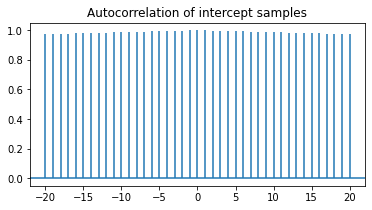

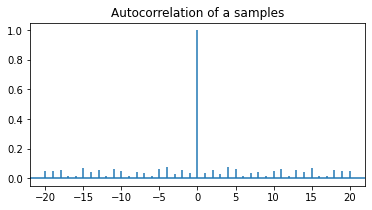

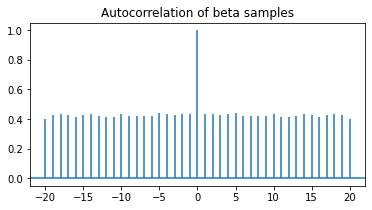

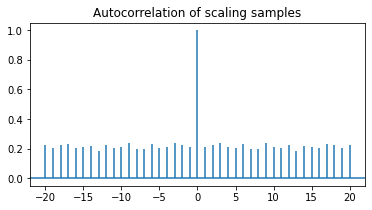

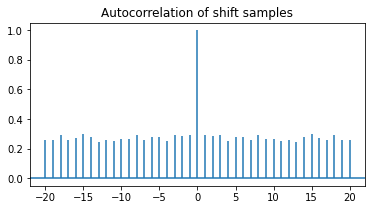

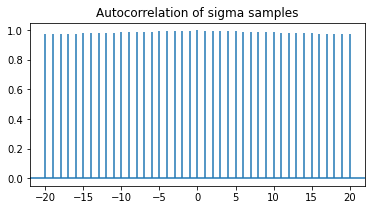

In [10]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in improved_parameters:
    plt.figure(figsize=(6, 3))
    plot_acf(improved_model_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

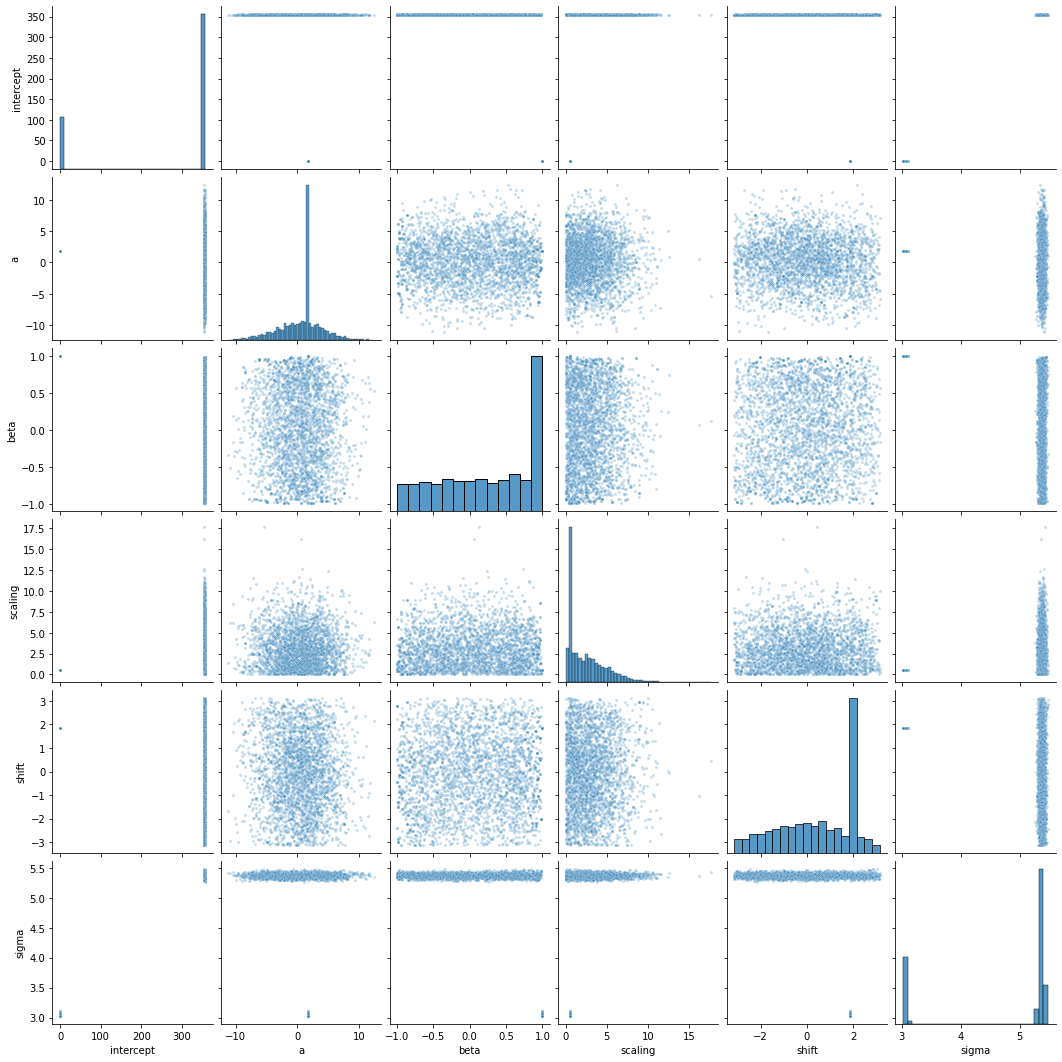

In [11]:
# Make pair plot of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([improved_model_samples[param] for param in improved_parameters]),
    columns=improved_parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

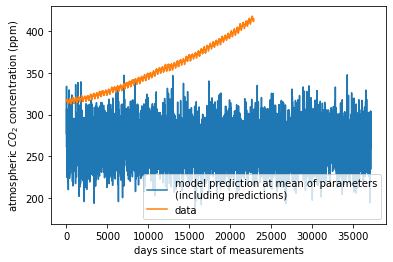

In [12]:
mean_intercept, mean_a, mean_beta, mean_scaling, mean_shift, mean_sigma = [np.mean(improved_model_samples[x]) for x in improved_parameters]
x = [int(f) for f in np.arange(0, (date(2060,1,3)-date.fromisoformat(just_values[0][0]))/timedelta(days = 1), 7)]
y = [np.random.normal(mean_intercept + mean_a*pow(mean_beta, i) + mean_scaling * (4/5*np.sin(-np.pi*i/365.25 + mean_shift)+ 1/5*np.sin(-2*np.pi*i/365.25 + mean_shift) + 4/105*np.sin(-3*np.pi*i/365.25 + mean_shift) + 1/280*np.sin(-4*np.pi*i/365.25 + mean_shift)),mean_sigma**2) for i in x]
plt.plot(x,y, label ='model prediction at mean of parameters\n(including predictions)')
plt.plot(time,co2_data, label='data')
plt.ylabel('atmospheric $CO_2$ concentration (ppm)')
plt.xlabel('days since start of measurements')
plt.legend()
plt.show()

In [ ]:
# find 95% interval of the normal distribution
mini = y[-1]-mean_sigma*1.96
maxi = y[-1]+mean_sigma*1.96

In [ ]:
# mean exceding 450
for i, value in enumerate(y):
    if value > 450:
        print(date.fromisoformat(just_values[0][0])+timedelta(days=x[i]))
        break

# lower bound for exceding 450
for i, value in enumerate(y):
    if value-mean_sigma*1.96 > 450:
        print(date.fromisoformat(just_values[0][0])+timedelta(days=x[i]))
        break